# Q1: Simple CNN network for PASCAL multi-label classification (20 points)
Now let’s try to recognize some natural images. We provided some starter code for this task. The following steps will guide you through the process.


## 1.1 Setup the dataset
We start by modifying the code to read images from the PASCAL 2007 dataset. The important thing to note is that PASCAL can have multiple objects present in the same image. Hence, this is a multi-label classification problem, and will have to be tackled slightly differently.


First, download the data. `cd` to a location where you can store 0.5GB of images. Then run:
```
wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
tar -xf VOCtrainval_06-Nov-2007.tar

wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
tar -xf VOCtest_06-Nov-2007.tar
cd VOCdevkit/VOC2007/
```

## 1.2 Write a dataloader with data augmentation (5 pts)
**Dataloader** The first step is to write a [pytorch data loader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) which loads this PASCAL data. Browse the folders and files under `VOCdevkit` to understand the structure and labeling. Complete the functions `preload_anno` and `__getitem__` in `voc_dataset.py` according to the following instructions and the instructions in the code. More information about the dataset can be found [here](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/devkit_doc_07-Jun-2007.pdf). We will use data in ‘trainval’ for training and ‘test’ for testing.

- `preload_anno`: This function will be called when the dataloader is initialized. We will load the annotations under folder `Annotations`. Each .xml file in the `Annotations` folder corresponds to the image with the same name under `JPEGImages`. In this function, we need to load `label` and `weight` vectors for each image according to the .xml file. 
- The labels should be 0 by default. Assign 1 for each class label in the .xml file. For example, in 000001.xml, the label vector should have 1s at the class indices correspond to 'dog' and 'person'. The rest of the vector should be 0.
- The weights should be 1 by defatul. For each class label in the image, if 'difficult'=1 (which means it is ambiguous), we will assign 0 for the weight vector at this class index. This weight will be used when we calculate the test performance. We will not consider the ambiguous labels during testing.

- `__getitem__`: This function will be called when the dataloader is called during training. It takes as input the index, and returns a tuple - `(image, label, weight)`. You need to load the image from the `JPEGImages` folder and load the corresponding label and weight using `self.anno_list`.


**Data Augmentation** Modify `__getitem__` to randomly *augment* each datapoint using [TORCHVISION.TRANSFORMS](https://pytorch.org/vision/stable/transforms.html).  Make sure the data augmentation is only used for training data (based on self.split). Please describe what data augmentation you implement.

- Before any augmentation, resize all the images based on `self.size`.

* **Hint**: Since we are training a model from scratch on this small dataset, it is important to perform basic data augmentation to avoid overfitting. Add random crops and left-right flips when training, and do a center crop when testing, etc. As for natural images, another common practice is to subtract the mean values of RGB images from ImageNet dataset. The mean values for RGB images are: `[123.68, 116.78, 103.94]`. You may also rescale the images to `[−1, 1]`. There is no "correct" answer here! Feel free to search online about the data augmentation methods people usually use.

### DESCRIBE YOUR AUGMENTATION PIPELINE HERE**
**Train Augmentations:**

My train augmentations consisted of normalization, where the mean and std were from the ImageNet dataset, random horizontal flipping, random cropping, brightness variation, and random rotation.

<br>

**Test Augmentations:**

My test augmentations consisted of just the same normalization as in the train augmentations.

## 1.3 Measure Performance (5 pts)
To evaluate the trained model, we will use a standard metric for multi-label evaluation - [mean average precision (mAP)](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html). Please implement `eval_dataset_map` in `utils.py` - this function will evaluate a model's map score using a given dataset object. You will need to make predictions on the given dataset with the model and call `compute_ap` to get average precision.


Please describe how to compute AP for each class(not mAP).
**YOUR ANSWER HERE**

The average precision is an estimate of the area under the precision-recall curve for a single class.

## 1.4 Let's Start Training! (5 pts)
Fill out the loss function for multi-label classification in `trainer.py` and start training. In this question, you will use the model that you finished in the previous question (with proper non-linearities).

Initialize a fresh model and optimizer. Then run your training code for 5 epochs and print the mAP on test set. The resulting mAP should be around 0.24. Make sure to tune the hyperparameters.

In [1]:
import torch
import trainer
from utils import ARGS
from simple_cnn import SimpleCNN
from voc_dataset import VOCDataset

# create hyperparameter argument class
# Use image size of 64x64 in Q1. We will use a default size of 224x224 for the rest of the questions.
args = ARGS(epochs=5, inp_size=64, batch_size=20, lr=0.001, gamma=0.7, log_every=100, val_every=100, use_cuda=True)
print(args)

args.batch_size = 20
args.device = cuda
args.epochs = 5
args.gamma = 0.7
args.inp_size = 64
args.log_every = 100
args.lr = 0.001
args.save_at_end = True
args.save_freq = 10
args.step_size = 1
args.test_batch_size = 1000
args.val_every = 100



In [2]:
# initializes the model
model = SimpleCNN(num_classes=len(VOCDataset.CLASS_NAMES), inp_size=64, c_dim=3)
# initializes Adam optimizer and simple StepLR scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)
# trains model using your training code and reports test map
test_ap, test_map = trainer.train(args, model, optimizer, scheduler)
print('test map:', test_map)

Train Epoch: 0 [0 (0%)]	Loss: 0.678817
0.07707119113333445
Train Epoch: 0 [100 (40%)]	Loss: 0.237034
0.1561614832181566
Train Epoch: 0 [200 (80%)]	Loss: 0.202147
0.1796810966876655
Train Epoch: 1 [300 (20%)]	Loss: 0.186375
0.19904037898820232
Train Epoch: 1 [400 (59%)]	Loss: 0.226133
0.21088154400180642
Train Epoch: 1 [500 (99%)]	Loss: 0.197145
0.2248062588520447
Train Epoch: 2 [600 (39%)]	Loss: 0.209637
0.23705273588627337
Train Epoch: 2 [700 (79%)]	Loss: 0.129279
0.24052953987531023
Train Epoch: 3 [800 (19%)]	Loss: 0.215028
0.24946973122634647
Train Epoch: 3 [900 (59%)]	Loss: 0.195588
0.2513845313579141
Train Epoch: 3 [1000 (98%)]	Loss: 0.226564
0.25634061037505435
Train Epoch: 4 [1100 (38%)]	Loss: 0.204269
0.2620287092032275
Train Epoch: 4 [1200 (78%)]	Loss: 0.185575
0.26824479423976694
test map: 0.265469733014256


[TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard) is an awesome visualization tool. It was firstly integrated in [TensorFlow](https://www.tensorflow.org/). It can be used to visualize training losses, network weights and other parameters.

To use TensorBoard in Pytorch, there are two options: [TensorBoard in Pytorch](https://pytorch.org/docs/stable/tensorboard.html) (for Pytorch >= 1.1.0) or [TensorBoardX](https://github.com/lanpa/tensorboardX) - a third party library. Following these links to add code in `trainer.py` to visualize the testing MAP and training loss in Tensorboard. *You may have to reload the kernel for these changes to take effect.*

Show clear screenshots of the learning curves of testing MAP and training loss for 5 epochs (batch size=20, learning rate=0.001). Please evaluate your model to calculate the MAP on the testing dataset every 100 iterations.

In [2]:
args = ARGS(epochs=5, batch_size=20, lr=0.001, inp_size=64)
model = SimpleCNN(num_classes=len(VOCDataset.CLASS_NAMES), inp_size=64, c_dim=3)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)
test_ap, test_map = trainer.train(args, model, optimizer, scheduler)
print('test map:', test_map)

Train Epoch: 0 [0 (0%)]	Loss: 0.684341
0.07935421723358299
Train Epoch: 0 [100 (40%)]	Loss: 0.245733
0.14766045432429703
Train Epoch: 0 [200 (80%)]	Loss: 0.201044
0.16583498376725417
Train Epoch: 1 [300 (20%)]	Loss: 0.208218
0.1895160060769484
Train Epoch: 1 [400 (59%)]	Loss: 0.181977
0.21374501495370785
Train Epoch: 1 [500 (99%)]	Loss: 0.184173
0.22523008009212736
Train Epoch: 2 [600 (39%)]	Loss: 0.199220
0.24227686280080346
Train Epoch: 2 [700 (79%)]	Loss: 0.233587
0.2495561492268977
Train Epoch: 3 [800 (19%)]	Loss: 0.194873
0.25738166321231637
Train Epoch: 3 [900 (59%)]	Loss: 0.178514
0.2609400041308615
Train Epoch: 3 [1000 (98%)]	Loss: 0.183231
0.2633717690589613
Train Epoch: 4 [1100 (38%)]	Loss: 0.203642
0.2711326789735352
Train Epoch: 4 [1200 (78%)]	Loss: 0.180814
0.27232201110650467
test map: 0.2787274906527557


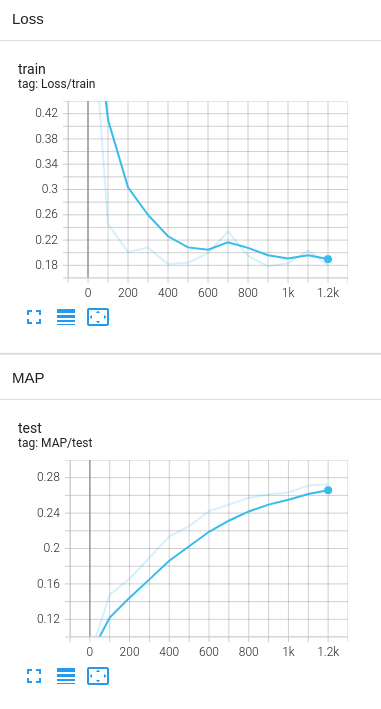